### Work and Health
1. Importing the data
* Functions to filter & clean the data
2. data exploration
    1. basic exploration
    2. statistical exploration
    3. visual exploration

In [1]:
#Import the basic libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import unicodedata


#plt.style.use('ggplot')
sns.set_style("white")
#sns.color_palette('Set2')
#sns.set_style("whitegrid")
sns.color_palette("husl", 20)
sns.set_context({"figure.figsize": (18, 5)})


rcParams['axes.titlepad'] = 20 
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False

# remove warnings
import warnings
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=FutureWarning)


## random name to save figs
import string
import random


def random_str():
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(10))


### Import diseases data

In [2]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [3]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    return df

### Import health cost data

In [4]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [5]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [6]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [7]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_per_cap'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [8]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [9]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [10]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [11]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [12]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [13]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours'] * 1000
    
    return df

## Load regions

In [14]:
df_regions = (pd.read_csv("../raw data/europe-regions.csv", header = None, names=['location_name', 'region'])
              .set_index('location_name')
             )
#df_regions.columns = ['location_name', 'region']
df_regions.head()

,region
location_name,
Russia,Eastern Europe
Germany,Western Europe
United Kingdom,Northern Europe
France,Western Europe
Italy,Southern Europe


### SUMMARY OF ALL DATA GATHERED

### Merging all, considering all genders & yr = 2011

In [15]:
def remove_accent_chars_join(s):
    return u"".join([c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c)])

def clean_column_names(column): 
    return remove_accent_chars_join(
        column.lower()
        .replace(" ", "_")
        .replace("/", "")
        .replace(".", "")
        .replace(",", "")
    )

def transform(df,  year):
    
    #group all mental disordes in new variable
    df['mental_disorders'] = df['anxiety_disorders'] + df['bipolar_disorder'] + df['depressive_disorders']
    
    
    #group all costs in one single cost variable
    #df['total_health_cost'] = df['private_cost'] + df['public_cost']
    df['total_health_cost'] = df['public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders'] + df['musculoskeletal_disorders'] + df['dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    df['agriculture_percap'] = (df['per_total_employment'] * df['per_total_agriculture'])/10000
    df['industry_percap'] = (df['per_total_employment']*df['per_total_industry'])/10000
    df['services_percap'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['unemp_percapita'] = (df['unemployment_rate']*df['total_labor_force'])/10000
    
    df['year'] = int(year)
    
    return df


def get_by_year(year, country_list = []):
    
    # -------------------------------
    # Load
    df1 = get_df_dis(df_diseases, year, 'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost, year)
    df3 = get_gdp(df_gdp, year)
    df4 = get_employment(df_employment, year)
    df5 = get_unemp_lforce(df_unemp_lforce, year)
    df6 = get_hours_work(df_hours_work, year)
    
    # -------------------------------
    # merge by index = localname
    df = (df1
          .merge(df2, right_index=True, left_index=True, how='inner')
          .merge(df3, right_index=True, left_index=True, how='inner')
          .merge(df4, right_index=True, left_index=True, how='inner')
          .merge(df5, right_index=True, left_index=True, how='inner')
          .merge(df6, right_index=True, left_index=True, how='inner')
          #.merge(df_regions, right_index=True, left_index=True, how='left')
         )
    
    # -------------------------------
    # Filter by country
    if len(country_list):
        df = df[df.index.isin(country_list)]
    
    # -------------------------------
    # Transform and Clean
    
    # clean columns names
    df.columns = df.columns.map(clean_column_names)
    
    columns_to_keep = ['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita']
    
    return (df
            .pipe(transform, year)
            [columns_to_keep]
           )

In [16]:
# Load Regions
#df_regions = df_regions = (pd.read_csv("../raw data/europe-regions.csv", header = None, names=['location_name', 'region'])
#              .set_index('location_name')
#             )
#df_regions.head()

In [17]:

"""
eu_countries_list = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 
                     'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 
                     'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
                     'Luxembourg', 'Malta', 'Malta', 'Netherlands', 'Poland', 'Portugal', 
                     'Romania', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom',
                     #'Cyprus'
                    ]
"""

eu_countries_list = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 
                     'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 
                     'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
                     'Luxembourg', 'Malta', 'Malta', 'Netherlands', 'Poland', 'Portugal', 
                     'Romania', 'Spain', 'Sweden', 'United Kingdom',
                     'Cyprus'
                    ]

#Chéquia, Eslováquia e Eslovénia


"""
# coutries using Euro
eu_countries_list = ['Austria', 'Belgium', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 
                     'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                     'Malta', 'Netherlands', 'Portugal', 'Slovakia', 'Slovenia' 'Spain'
                    ]
"""

#df_2009 = get_by_year('2009', country_list=eu_countries_list)
df_2011 = get_by_year('2011', country_list=eu_countries_list)
df_2017 = get_by_year('2017', country_list=eu_countries_list)


In [18]:
df_2011.head()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,2011,3245.752554,4967.904233,51374.958407,57.279999,153282063.0,4585.610346,3246.044434,12799.267132,0.028296,0.149100,0.395461,0.027369
Belgium,2011,3215.364495,5031.871074,47348.525020,49.279999,167802886.0,5455.438481,3244.739014,13702.674050,0.006406,0.114477,0.371916,0.037892
Bulgaria,2011,5950.488801,6569.524981,7809.425062,46.619999,119607021.0,4021.589656,603.789062,16541.603439,0.031608,0.146667,0.287972,0.059149
Croatia,2011,5846.219496,6443.573526,14609.524352,44.730000,64461098.0,4595.150412,1321.966064,16884.943434,0.065261,0.125020,0.257019,0.070876
Cyprus,2011,3345.325004,4813.597457,32396.385744,58.230000,20996901.0,4286.473095,1031.945435,12445.395555,0.022302,0.121701,0.438297,0.049667


In [19]:
df_2011.index

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'United Kingdom'],
      dtype='object', name='location_name')

In [20]:
df_2017.tail()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Portugal,2017,3191.839335,5617.869823,21490.429863,53.790001,1.835819e+08,7415.309734,1881.749634,16225.018891,0.034426,0.133076,0.370398,0.052351
Romania,2017,5801.340545,6563.445599,10807.795391,52.290001,3.391752e+08,3732.228719,1074.921143,16097.014863,0.119117,0.157497,0.246286,0.027115
Spain,2017,3200.585826,5428.195434,28170.167864,48.000000,7.085927e+08,7240.848503,2460.455078,15869.629764,0.020880,0.096288,0.362832,0.099859
Sweden,2017,3349.353758,5287.213848,53791.508730,60.000000,1.761930e+08,6022.080643,4776.607910,14658.648249,0.010980,0.108960,0.480060,0.043223
United Kingdom,2017,3391.833810,5788.811432,40361.417383,59.810001,1.180674e+09,6014.127703,3555.262451,15194.772945,0.006938,0.109213,0.481949,0.027067


In [21]:
print(df_2011.columns)
df_2011.head()

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')


,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,2011,3245.752554,4967.904233,51374.958407,57.279999,153282063.0,4585.610346,3246.044434,12799.267132,0.028296,0.149100,0.395461,0.027369
Belgium,2011,3215.364495,5031.871074,47348.525020,49.279999,167802886.0,5455.438481,3244.739014,13702.674050,0.006406,0.114477,0.371916,0.037892
Bulgaria,2011,5950.488801,6569.524981,7809.425062,46.619999,119607021.0,4021.589656,603.789062,16541.603439,0.031608,0.146667,0.287972,0.059149
Croatia,2011,5846.219496,6443.573526,14609.524352,44.730000,64461098.0,4595.150412,1321.966064,16884.943434,0.065261,0.125020,0.257019,0.070876
Cyprus,2011,3345.325004,4813.597457,32396.385744,58.230000,20996901.0,4286.473095,1031.945435,12445.395555,0.022302,0.121701,0.438297,0.049667


### Plot Global

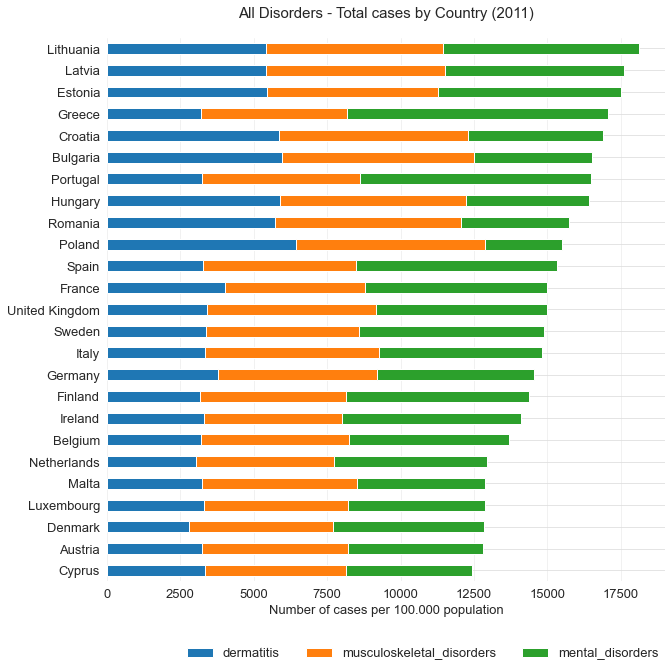

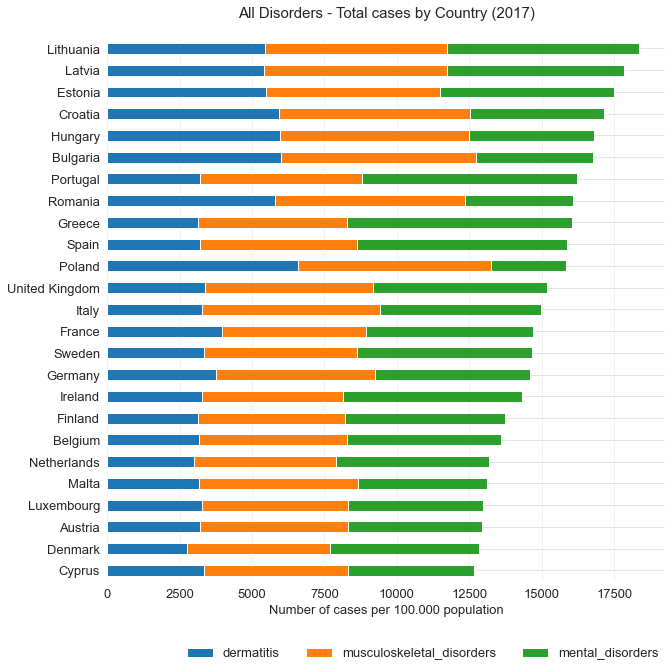

In [186]:
import matplotlib.patches as mpatches

def barplot_deseases_by_countries_OLD(df, x, y, t='', l='', hlines=[]):
    
    fig, axes = plt.subplots(1, sharex=False, figsize=(18,6))
    #sns.histplot(data=df, axes = axes, x=x, hue=h, weights=w, multiple='stack', shrink=0.8)
    
    sns.barplot( x=x, y=y, data=df, estimator=sum, ci=None, color='#dedede', label='1')
    sns.barplot( x=x, y='mental_disorders', data=df, estimator=sum, ci=None, color='#2d73f5', label='2')
    sns.barplot( x=x, y='musculoskeletal_disorders', data=df, estimator=sum, ci=None, color='#78d237', label='3')
    sns.barplot( x=x, y='dermatitis', data=df, estimator=sum, ci=None, color='#ff6358', label='4')
    #lightsteelblue darkseagreen cornflowerblue

    
    for hline in hlines:
        axes.axhline(hline, ls='--', color='#333333', alpha=0.4)

    
    leg_1 = mpatches.Patch(color='#2d73f5', label='mental_disorders')
    leg_2 = mpatches.Patch(color='#78d237', label='musculoskeletal_disorders')
    leg_3 = mpatches.Patch(color='#ff6358', label='dermatitis')
    
    #axes.xaxis.grid(color='#dedede')
    #axes.yaxis.grid(color='#dadada')
    
    axes.set_title(t)
    axes.set_ylabel(l)
    axes.set_xlabel('')
    
    plt.legend(ncol=3, handles=[leg_1, leg_2, leg_3], bbox_to_anchor=(1.01, -0.23), frameon=False)
    #plt.legend([leg_1, leg_2, leg_3], ['u','v','u+v', 'dd'])

    sns.despine(top=True, right=True, left=True, bottom=True)
    #legend = axes.get_legend()
    #legend.set_bbox_to_anchor((1, 1))
    
    plt.xticks(rotation=45, fontsize=12)

    plt.show()
    
    
    
def barplot_deseases_by_countries(df, t='', l=''):
    
    ax = (df.copy().sort_values('all_disorders')[['dermatitis', 'musculoskeletal_disorders','mental_disorders' ]]
            .plot.barh(stacked=True)
         )
    
    ax.figure.set_size_inches(10, 10)

    plt.title(t, fontsize=15)

    plt.ylabel('')
    plt.xlabel(l, fontsize=13)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    ax.yaxis.grid(color='#dedede') # horizontal linessx
    ax.xaxis.grid(color='#eeeeee') # horizontal linessx

    #plt.legend(framealpha=1, frameon=True);
    plt.legend(ncol=3, bbox_to_anchor=(1.01, -0.1), frameon=False, fontsize=13)
    sns.despine(top=True, right=True, left=True, bottom=True)

    
    
    #ax.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)

    plt.show()
    
barplot_deseases_by_countries(df_2011,
                         t ='All Disorders - Total cases by Country (2011)', 
                         l = 'Number of cases per 100.000 population'
                        )


barplot_deseases_by_countries(df_2017, 
                         t ='All Disorders - Total cases by Country (2017)', 
                         l = 'Number of cases per 100.000 population'
                        )
                         #hlines = [2500, 5000,7500])





In [75]:
df_2017[['dermatitis', 'musculoskeletal_disorders', ]].head()

,dermatitis,musculoskeletal_disorders
location_name,,
Austria,3214.397826,5095.832759
Belgium,3183.096989,5112.738831
Bulgaria,6003.364069,6725.235781
Croatia,5931.046451,6579.827371
Cyprus,3329.269290,4998.260371


In [74]:
df_2017.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

## Variation Overview 

In [23]:
df_variation = (df_2017 - df_2011)
df_variation.head()





,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,6,-31.354727,127.928526,-3948.446447,-0.090000,-25705.0,28.955898,860.283691,125.529697,-0.005821,-0.006582,0.011446,0.005917
Belgium,6,-32.267506,80.867757,-3155.901993,0.320000,4487991.0,-162.317024,771.398193,-113.716773,-0.000653,-0.011508,0.015361,-0.000046
Bulgaria,6,52.875268,155.710800,524.656665,5.420002,6922717.0,13.850054,255.217590,222.436122,0.004872,0.008933,0.040349,-0.024985
Croatia,6,84.826955,136.253846,-1157.899405,1.100002,-693187.0,60.878458,147.257568,281.959258,-0.033272,-0.003937,0.048255,-0.013021
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169801.0,54.612191,-4.412598,223.219392,-0.008286,-0.027244,0.007285,0.019163


In [24]:
df_variation

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,6,-31.354727,127.928526,-3948.446447,-0.090000,-25705.0,28.955898,860.283691,125.529697,-0.005821,-0.006582,0.011446,0.005917
Belgium,6,-32.267506,80.867757,-3155.901993,0.320000,4487991.0,-162.317024,771.398193,-113.716773,-0.000653,-0.011508,0.015361,-0.000046
Bulgaria,6,52.875268,155.710800,524.656665,5.420002,6922717.0,13.850054,255.217590,222.436122,0.004872,0.008933,0.040349,-0.024985
Croatia,6,84.826955,136.253846,-1157.899405,1.100002,-693187.0,60.878458,147.257568,281.959258,-0.033272,-0.003937,0.048255,-0.013021
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169801.0,54.612191,-4.412598,223.219392,-0.008286,-0.027244,0.007285,0.019163
Denmark,6,-32.860220,51.216535,-4143.548952,-0.250000,1021580.0,-24.794358,920.208008,-6.438043,-0.001739,-0.006870,0.006051,-0.013141
Estonia,6,10.487242,200.185402,2836.912766,6.430000,2178993.0,-241.414483,569.638794,-30.741840,-0.002452,0.006010,0.060796,-0.038734
Finland,6,-28.334860,99.306189,-4745.334417,-1.509998,-1816818.0,-732.320640,399.097168,-661.349312,-0.003161,-0.007980,-0.004014,0.004195
France,6,-33.524683,165.427360,-4978.571014,-0.860001,-10633581.0,-444.216544,783.762939,-312.313867,-0.001752,-0.010719,0.003871,0.002805


In [25]:
df_variation.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

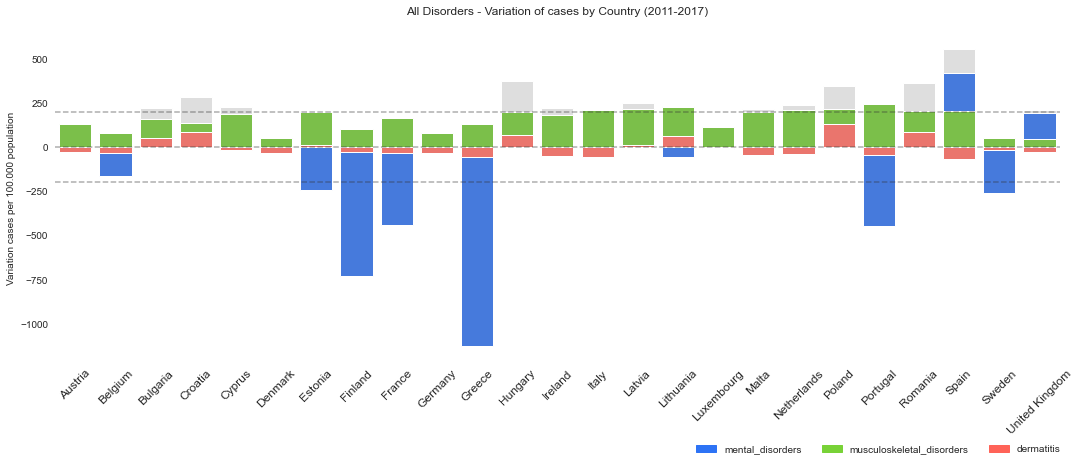

In [27]:
barplot_deseases_by_countries(df_variation.reset_index(), x='location_name', 
                         y='all_disorders', 
                         t ='All Disorders - Variation of cases by Country (2011-2017)', 
                         l = 'Variation cases per 100.000 population',
                         hlines = [0, 200, -200])

In [29]:
df_2011.head()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,2011,3245.752554,4967.904233,51374.958407,57.279999,153282063.0,4585.610346,3246.044434,12799.267132,0.028296,0.149100,0.395461,0.027369
Belgium,2011,3215.364495,5031.871074,47348.525020,49.279999,167802886.0,5455.438481,3244.739014,13702.674050,0.006406,0.114477,0.371916,0.037892
Bulgaria,2011,5950.488801,6569.524981,7809.425062,46.619999,119607021.0,4021.589656,603.789062,16541.603439,0.031608,0.146667,0.287972,0.059149
Croatia,2011,5846.219496,6443.573526,14609.524352,44.730000,64461098.0,4595.150412,1321.966064,16884.943434,0.065261,0.125020,0.257019,0.070876
Cyprus,2011,3345.325004,4813.597457,32396.385744,58.230000,20996901.0,4286.473095,1031.945435,12445.395555,0.022302,0.121701,0.438297,0.049667


In [30]:
df_2011.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

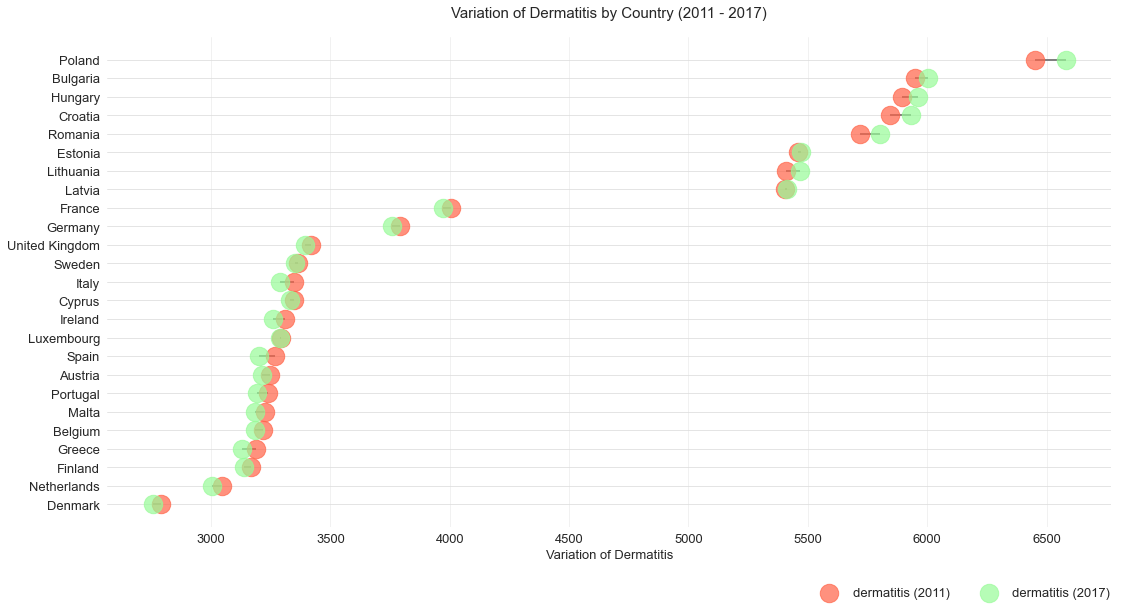

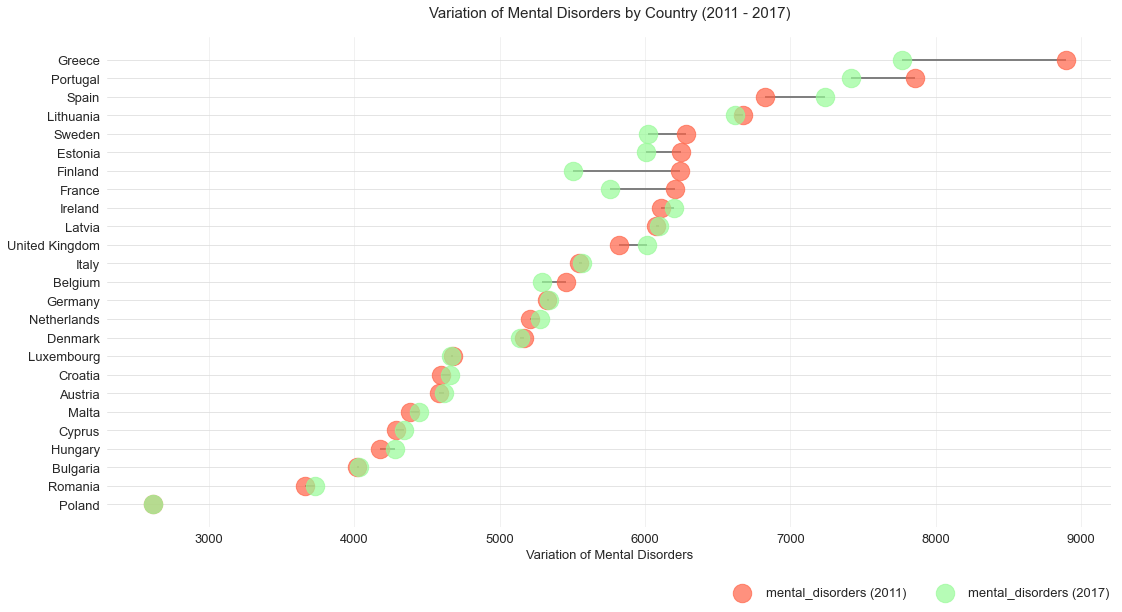

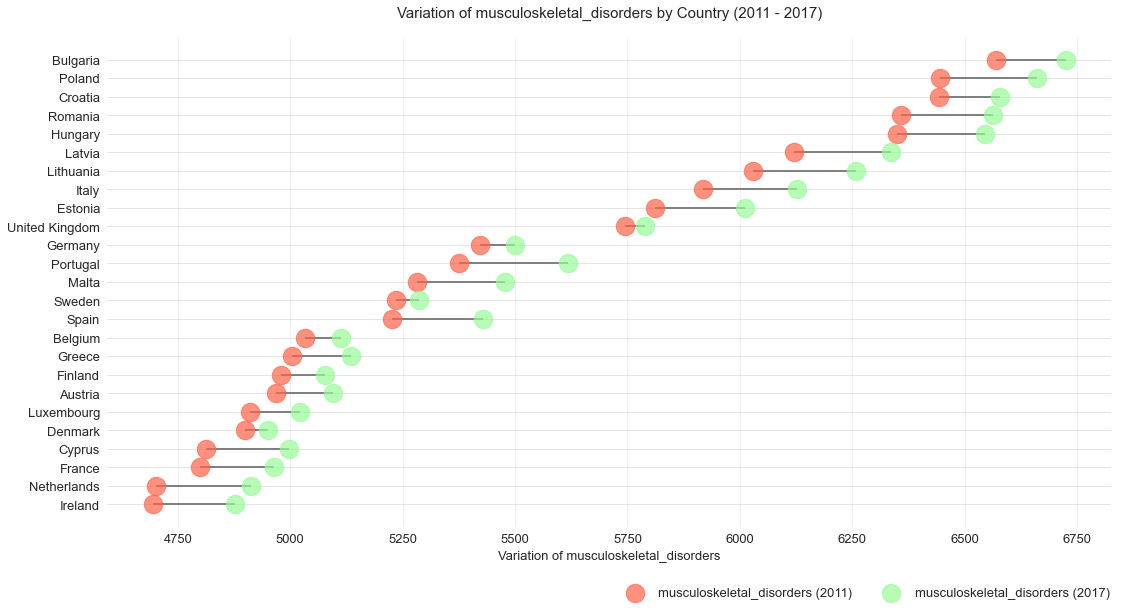

In [187]:
# Plot Variation of Mental Disorders by Euro Country
def plot_variation_by_countries(df1, df2, desease = '', title='', xlabel=''):
    fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 9))
    plt.scatter(df1[desease], df1.index,  marker='o', color='tomato', s=340, alpha=0.7, label=f'{desease} (2011)', zorder=2)
    plt.scatter(df2[desease],  df2.index, marker='o', color='palegreen', alpha=0.7, s=340, label=f'{desease} (2017)', zorder=2)
    plt.hlines(df1.index, df1[desease], df2[desease], lw=2, color='gray', zorder=1)

        
    plt.title(title, fontsize=15)
    
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=13)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    axes.yaxis.grid(color='#dedede') # horizontal linessx
    axes.xaxis.grid(color='#eeeeee') # horizontal linessx
    
    #plt.legend(framealpha=1, frameon=True);
    plt.legend(ncol=2, bbox_to_anchor=(1.01, -0.1), frameon=False, fontsize=13)
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.show()
    
    fig.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)


df_2011_sorted = df_2011.sort_values('dermatitis')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)  
plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='dermatitis', 
                            title='Variation of Dermatitis by Country (2011 - 2017)',
                            xlabel = 'Variation of Dermatitis'
                           
                           )

df_2011_sorted = df_2011.sort_values('mental_disorders')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)   
plot_variation_by_countries(df_2011_sorted, df_2017_sorted,
                            desease='mental_disorders', 
                            title='Variation of Mental Disorders by Country (2011 - 2017)',
                            xlabel = 'Variation of Mental Disorders'
                           )

df_2011_sorted = df_2011.sort_values('musculoskeletal_disorders')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)
plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='musculoskeletal_disorders', 
                            title='Variation of musculoskeletal_disorders by Country (2011 - 2017)',
                            xlabel = 'Variation of musculoskeletal_disorders'
                           )


#df_2017_sorted.head()

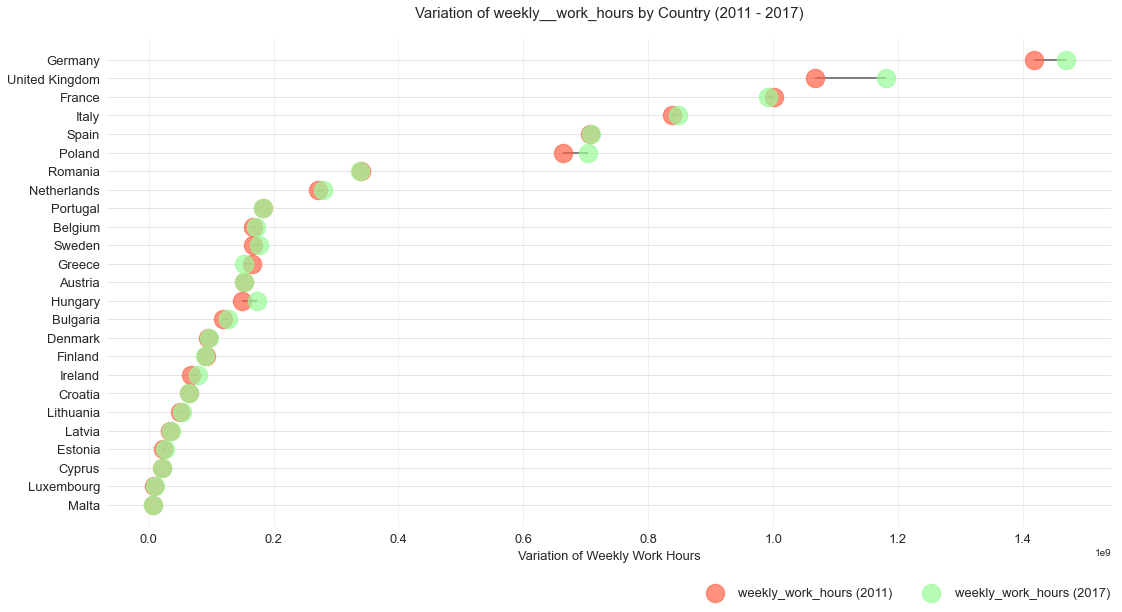

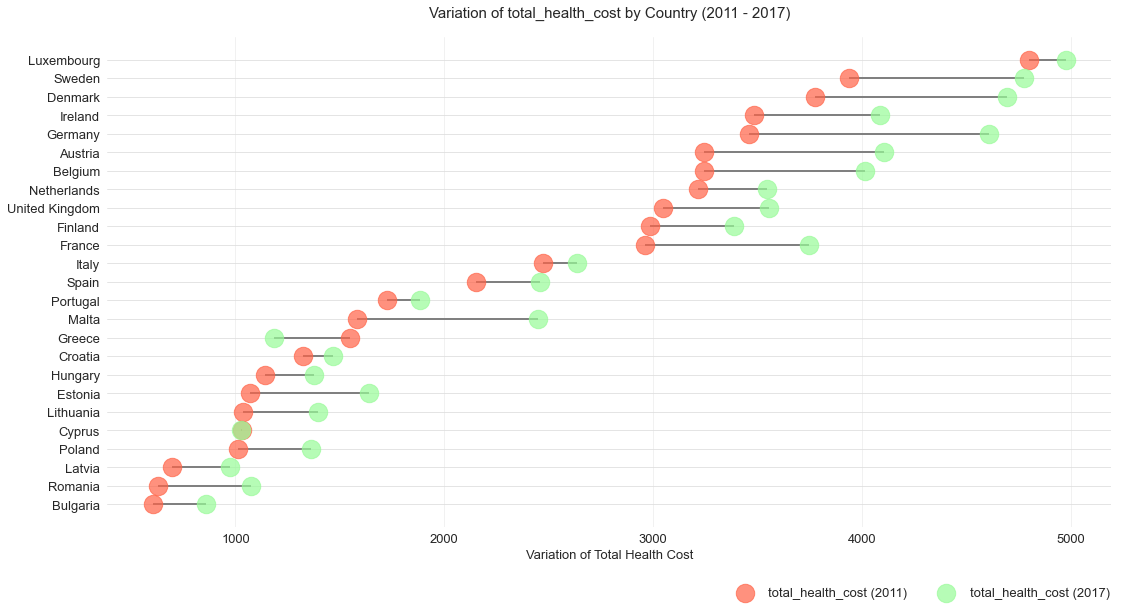

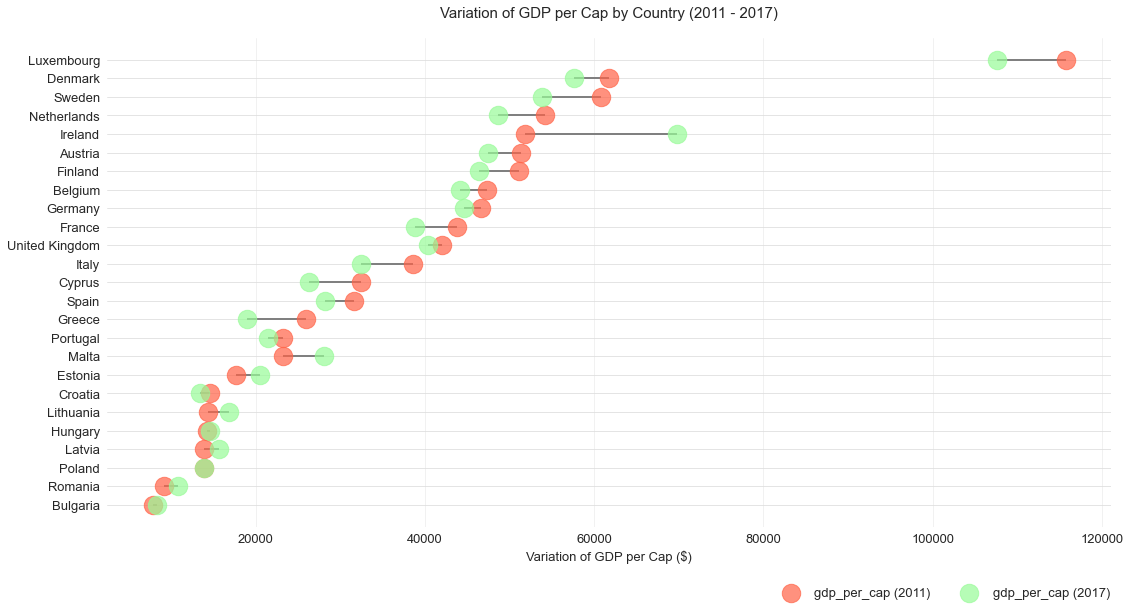

In [188]:
df_2011_sorted = df_2011.sort_values('weekly_work_hours')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)
plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='weekly_work_hours', 
                            title='Variation of weekly__work_hours by Country (2011 - 2017)',
                            xlabel='Variation of Weekly Work Hours'
                           )

df_2011_sorted = df_2011.sort_values('total_health_cost')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)
plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='total_health_cost', 
                            title='Variation of total_health_cost by Country (2011 - 2017)',
                            xlabel='Variation of Total Health Cost'
                           )

df_2011_sorted = df_2011.sort_values('gdp_per_cap')
df_2017_sorted = df_2017.reindex(df_2011_sorted.index, copy=True)
plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='gdp_per_cap', 
                            title='Variation of GDP per Cap by Country (2011 - 2017)',
                            xlabel='Variation of GDP per Cap ($)'
                           )

    

In [182]:
df_2011.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'yearly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

In [183]:
df_variation.head()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,yearly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita
location_name,,,,,,,,,,,,,
Austria,6,-31.354727,127.928526,-3948.446447,-0.090000,-25.705,28.955898,860.283691,125.529697,-0.005821,-0.006582,0.011446,0.005917
Belgium,6,-32.267506,80.867757,-3155.901993,0.320000,4487.991,-162.317024,771.398193,-113.716773,-0.000653,-0.011508,0.015361,-0.000046
Bulgaria,6,52.875268,155.710800,524.656665,5.420002,6922.717,13.850054,255.217590,222.436122,0.004872,0.008933,0.040349,-0.024985
Croatia,6,84.826955,136.253846,-1157.899405,1.100002,-693.187,60.878458,147.257568,281.959258,-0.033272,-0.003937,0.048255,-0.013021
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169.801,54.612191,-4.412598,223.219392,-0.008286,-0.027244,0.007285,0.019163


### PLOT

In [136]:
def plot_deseases_correlation_by_countries(df1, df2, desease = '', title='', xlabel='', ylabel=''):
    fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 6))
    plt.scatter(df1.index, df1[desease], marker='o', color='tomato', s=340, alpha=0.7, label=f'{desease} (2011)', zorder=2)
    plt.vlines(df1.index, df1[desease], df2[desease], lw=2, color='gray', zorder=1)
    plt.scatter(df2.index, df2[desease], marker='o', color='palegreen', alpha=0.7, s=340, label=f'{desease} (2017)', zorder=2)

    plt.title(title)

    axes.yaxis.grid(color='#dedede') # horizontal linessx
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.xticks(rotation=45, fontsize=12)

    plt.legend(framealpha=1, frameon=True);

    sns.despine()
    plt.show()
    
    fig.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)
    


In [137]:
df = df_variation.copy().reset_index()

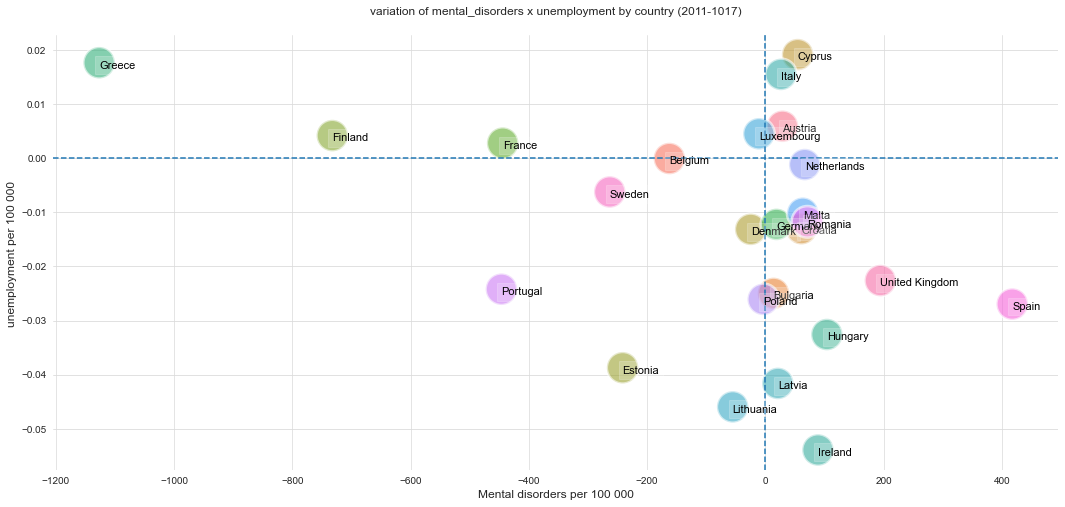

In [134]:
def plot_desease_correlation(_df, x='', y='', title='', xlim=None, ylim=None, xlabel='', ylabel=''):

    df = _df.copy().reset_index()

    fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 8))
    sns.scatterplot(ax=axes, data=df, x=x, y=y, s=1000, alpha = 0.6, hue='location_name')
    #sns.scatterplot(ax=axes[1], data=df_all, x='Depressive disorders', y='health_private_cost', hue='location_name')
    
    """ """
    for i in range(df.shape[0]):
        plt.text(x=df[x][i], y=df[y][i] - 0.001,  s= df['location_name'][i], 
              fontdict=dict(color="black", size=11),
              bbox=dict(facecolor="white",alpha=0.2))
     
    #axes.get_legend().remove()
    axes.xaxis.grid(color='#dedede')
    axes.yaxis.grid(color='#dadada')
    
    if xlim:
        axes.set_xlim(xlim)
        
    if ylim:
        axes.set_ylim(ylim)
    
    axes.axhline(0, ls='--')
    axes.axvline(0, ls='--')
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.title(title)
    #axes.get_legend().set_bbox_to_anchor((1, 1))
    axes.get_legend().remove()

    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.show()
    
    fig.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)
    

plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='unemp_percapita', 
                         title='variation of mental_disorders x unemployment by country (2011-1017)',
                         xlabel = 'Mental disorders per 100 000',
                         ylabel = 'unemployment per 100 000 '
                         #xlim=(-1200, 1200), ylim=(-0.06, 0.06)
                        )

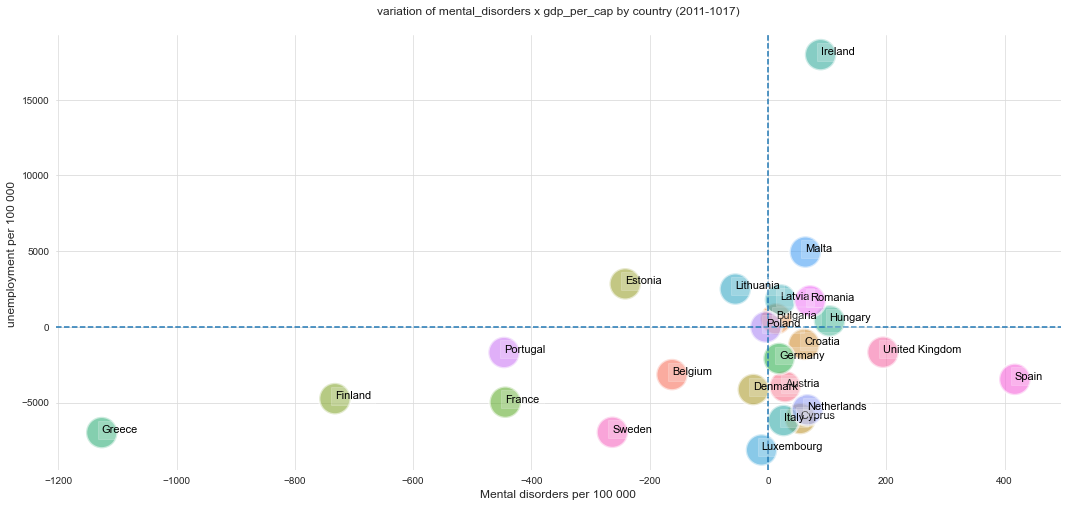

In [135]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='gdp_per_cap', 
                         title='variation of mental_disorders x gdp_per_cap by country (2011-1017)',
                         xlabel = 'Mental disorders per 100 000',
                         ylabel = 'unemployment per 100 000 '
                         #xlim=(-1200, 1200),
                         #ylim=(-45000, 45000)
                        )

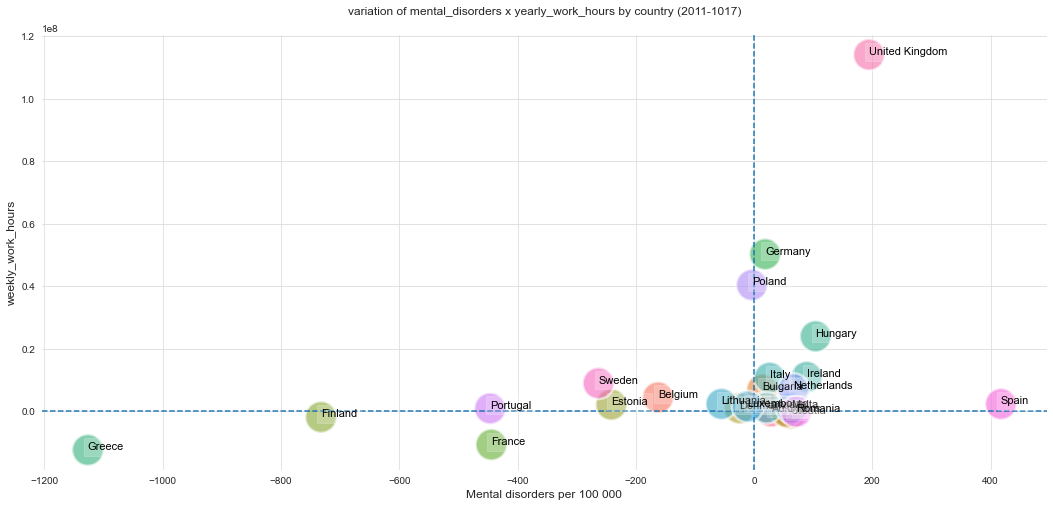

In [136]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='weekly_work_hours', 
                         title='variation of mental_disorders x yearly_work_hours by country (2011-1017)',
                         xlabel = 'Mental disorders per 100 000',
                         ylabel = 'weekly_work_hours'
                        )

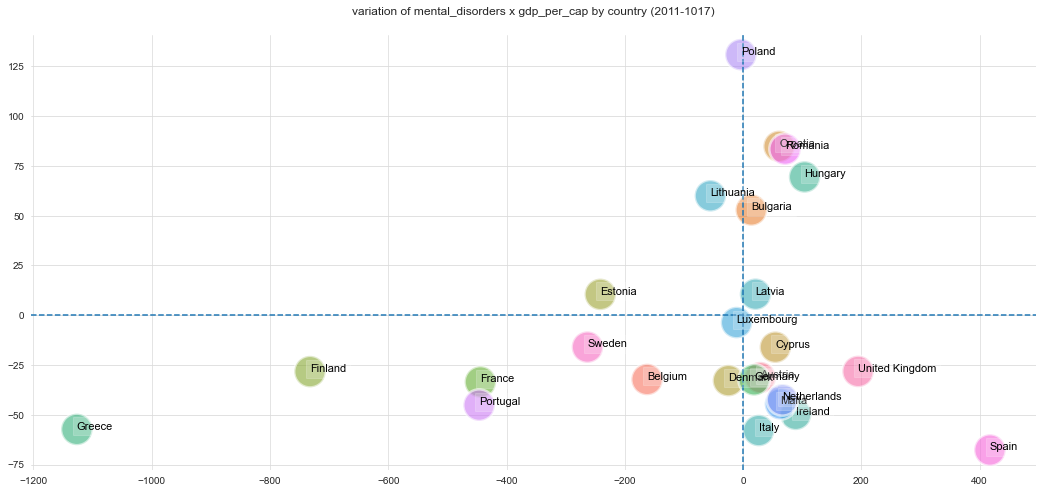

In [137]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='dermatitis', 
                         title='variation of mental_disorders x gdp_per_cap by country (2011-1017)',
                         #xlim=(-1200, 1200),
                         #ylim=(-15000, 45000)
                        )

In [287]:
df_variation.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'yearly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

### European troika 

Chipre; 
Grécia; 
Irlanda (12/2010 a 12/2012); Portugal (5/2011 a 5/2014) ; 
Espanha; 
Hungria (11/2008 a 11/2010); 
Letonia (1/2009 a 1/2012); 

Romenia (6/2011 a 3/2013)

In [153]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [154]:
df_2011.index.unique()

df_2011.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita'],
      dtype='object')

In [166]:
countries_troika = ['Cyprus', 'Greece', 'Portugal', 'Spain', 'Romania', 'Hungary', 'Latvia']

df_troika = df_2011[df_2011.index.isin(countries_troika)]


df_troika.head()


df = df_troika[['mental_disorders', 'unemp_percapita', 'total_health_cost', 'yearly_work_hours']]

scaler = MinMaxScaler()
scaler = StandardScaler()

df_temp = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)


KeyError: "['yearly_work_hours'] not in index"

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 6))
parallel_coordinates(df_temp.reset_index(), 'location_name', color=sns.color_palette("husl", 20))
    
#axes.xaxis.grid(color='#dedede')
axes.yaxis.grid(color='#dadada')

#axes.axhline(0, ls='--')
#axes.axvline(0, ls='--')

#plt.title(title)
#axes.get_legend().set_bbox_to_anchor((1, 1))
#axes.get_legend().remove()

sns.despine(top=True, right=True, left=True, bottom=True)
    
    
plt.show()

### MAP

In [ ]:
#!pip install pycountry
#!pip install geopandas
#!pip install geopy

In [138]:
import pycountry 
import geopandas
from geopandas import GeoDataFrame
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

In [139]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE



df = df_variation.copy()
# create a column for code 
df['CODE']=alpha3code(df.index)
df.head()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita,CODE
location_name,,,,,,,,,,,,,,
Austria,6,-31.354727,127.928526,-3948.446447,-0.090000,-25705.0,28.955898,860.283691,125.529697,-0.005821,-0.006582,0.011446,0.005917,AUT
Belgium,6,-32.267506,80.867757,-3155.901993,0.320000,4487991.0,-162.317024,771.398193,-113.716773,-0.000653,-0.011508,0.015361,-0.000046,BEL
Bulgaria,6,52.875268,155.710800,524.656665,5.420002,6922717.0,13.850054,255.217590,222.436122,0.004872,0.008933,0.040349,-0.024985,BGR
Croatia,6,84.826955,136.253846,-1157.899405,1.100002,-693187.0,60.878458,147.257568,281.959258,-0.033272,-0.003937,0.048255,-0.013021,HRV
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169801.0,54.612191,-4.412598,223.219392,-0.008286,-0.027244,0.007285,0.019163,CYP


In [140]:
longitude = []
latitude = []
   
# function to find the coordinate
# of a given city 
def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
          
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="your_app_name")
          
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    

# each value from city column
# will be fetched and sent to
# function find_geocode   
for i in (df.index):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)
#Showing the output produced as dataframe.





In [141]:
# now add this column to dataframe
df["Longitude"] = longitude
df["Latitude"] = latitude

In [142]:
df.head()

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,unemp_percapita,CODE,Longitude,Latitude
location_name,,,,,,,,,,,,,,,,
Austria,6,-31.354727,127.928526,-3948.446447,-0.090000,-25705.0,28.955898,860.283691,125.529697,-0.005821,-0.006582,0.011446,0.005917,AUT,13.200000,47.200000
Belgium,6,-32.267506,80.867757,-3155.901993,0.320000,4487991.0,-162.317024,771.398193,-113.716773,-0.000653,-0.011508,0.015361,-0.000046,BEL,4.666715,50.640281
Bulgaria,6,52.875268,155.710800,524.656665,5.420002,6922717.0,13.850054,255.217590,222.436122,0.004872,0.008933,0.040349,-0.024985,BGR,25.485662,42.607397
Croatia,6,84.826955,136.253846,-1157.899405,1.100002,-693187.0,60.878458,147.257568,281.959258,-0.033272,-0.003937,0.048255,-0.013021,HRV,17.011895,45.564344
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169801.0,54.612191,-4.412598,223.219392,-0.008286,-0.027244,0.007285,0.019163,CYP,33.145128,34.982302


In [143]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'location_name', 'CODE_2', 'gdp_md_est', 'geometry']

In [144]:
world

,pop_est,continent,location_name,CODE_2,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [145]:
df_merged = df.merge(world.set_index('location_name'), left_index=True, right_index=True)

#df_merged.shape

#df_merged.columns


df_merged_df = GeoDataFrame(df_merged)
df_merged_df.tail(20)


#type(df_merged_df)

,year,dermatitis,musculoskeletal_disorders,gdp_per_cap,per_total_employment,weekly_work_hours,mental_disorders,total_health_cost,all_disorders,agriculture_percap,...,services_percap,unemp_percapita,CODE,Longitude,Latitude,pop_est,continent,CODE_2,gdp_md_est,geometry
location_name,,,,,,,,,,,,,,,,,,,,,
Cyprus,6,-16.055713,184.662914,-6057.691399,-2.829998,-169801.0,54.612191,-4.412598,223.219392,-0.008286,...,0.007285,0.019163,CYP,33.145128,34.982302,1221549,Asia,CYP,29260.0,"POLYGON ((32.73178 35.14003, 32.91957 35.08783..."
Denmark,6,-32.860220,51.216535,-4143.548952,-0.250000,1021580.0,-24.794358,920.208008,-6.438043,-0.001739,...,0.006051,-0.013141,DNK,10.333328,55.670249,5605948,Europe,DNK,264800.0,"MULTIPOLYGON (((9.92191 54.98310, 9.28205 54.8..."
Estonia,6,10.487242,200.185402,2836.912766,6.430000,2178993.0,-241.414483,569.638794,-30.741840,-0.002452,...,0.060796,-0.038734,EST,25.331908,58.752378,1251581,Europe,EST,38700.0,"POLYGON ((27.98113 59.47537, 27.98112 59.47537..."
Finland,6,-28.334860,99.306189,-4745.334417,-1.509998,-1816818.0,-732.320640,399.097168,-661.349312,-0.003161,...,-0.004014,0.004195,FIN,25.920916,63.246778,5491218,Europe,FIN,224137.0,"POLYGON ((28.59193 69.06478, 28.44594 68.36461..."
France,6,-33.524683,165.427360,-4978.571014,-0.860001,-10633581.0,-444.216544,783.762939,-312.313867,-0.001752,...,0.003871,0.002805,FRA,1.888334,46.603354,67106161,Europe,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
Germany,6,-32.471862,78.163449,-2091.956656,1.740002,50269914.0,18.738522,1149.495850,64.430108,-0.001868,...,0.019191,-0.012229,DEU,10.423447,51.083420,80594017,Europe,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817..."
Greece,6,-57.364045,131.763320,-6986.074864,-2.450001,-12348622.0,-1126.632099,-363.349976,-1052.232824,-0.004131,...,-0.006698,0.017667,GRC,21.987713,38.995368,10768477,Europe,GRC,290500.0,"MULTIPOLYGON (((26.29000 35.29999, 26.16500 35..."
Hungary,6,69.463278,196.909603,389.688734,8.750000,24023576.0,104.037193,236.813110,370.410074,0.005087,...,0.051717,-0.032588,HUN,19.506094,47.181759,9850845,Europe,HUN,267600.0,"POLYGON ((22.08561 48.42226, 22.64082 48.15024..."
Ireland,6,-49.786487,182.116254,17973.437385,5.260002,11019183.0,88.956014,606.527588,221.285781,-0.000931,...,0.036288,-0.053940,IRL,-7.979460,52.865196,5011102,Europe,IRL,322000.0,"POLYGON ((-6.19788 53.86757, -6.03299 53.15316..."


In [146]:
df_merged_df.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'weekly_work_hours', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'agriculture_percap',
       'industry_percap', 'services_percap', 'unemp_percapita', 'CODE',
       'Longitude', 'Latitude', 'pop_est', 'continent', 'CODE_2', 'gdp_md_est',
       'geometry'],
      dtype='object')

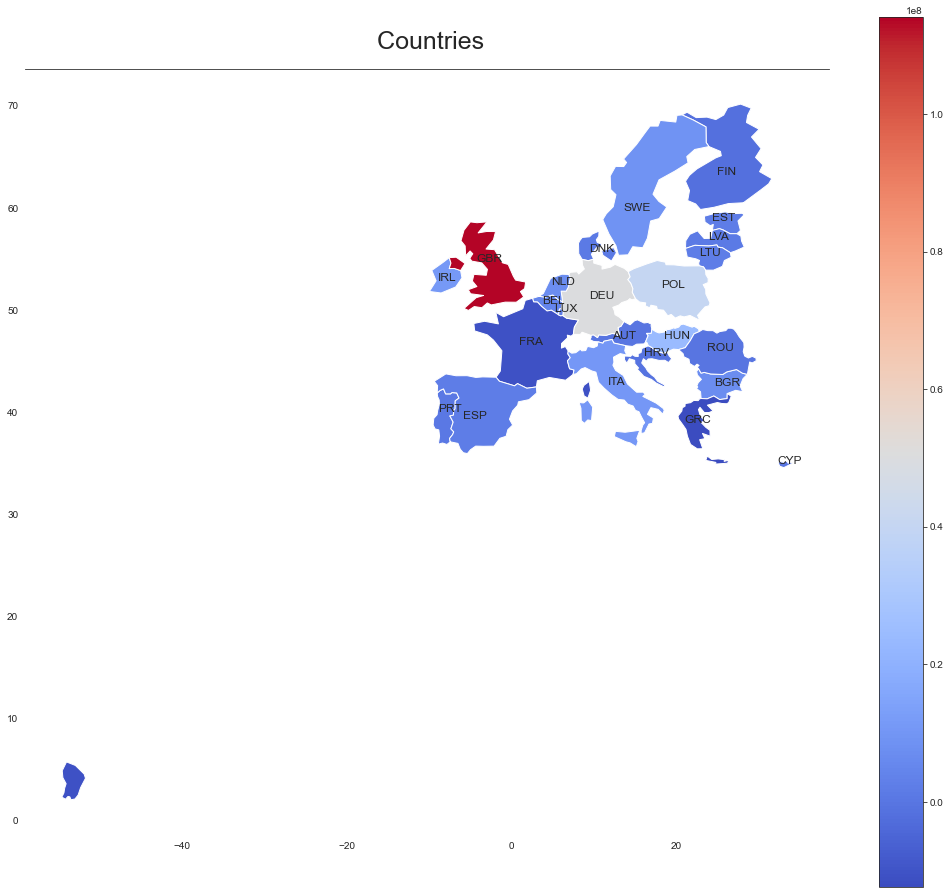

In [180]:
df_merged_df.plot(column='weekly_work_hours', 
           figsize=(18, 16),
           legend=True,cmap='coolwarm')
plt.title(' Countries', fontsize=25)


# add countries names and numbers 
for i in range(0, len(list(df.index)) - 1):
    plt.text(float(df_merged_df['Longitude'][i]-1.01),
             float(df_merged_df['Latitude'][i]),
             #"{}\n{}".format(df_merged_df['CODE'][i], round(df_merged_df['mental_disorders'][i])), size=12
             "{}".format(df_merged_df['CODE'][i]), size=12

            )
    
    
plt.show()

In [175]:
df_merged_df.loc['Portugal', ].head(20)

year                                  6
dermatitis                     -45.1805
musculoskeletal_disorders       241.851
gdp_per_cap                    -1696.48
per_total_employment               1.07
weekly_work_hours                930689
mental_disorders               -446.356
total_health_cost               157.046
all_disorders                  -249.686
agriculture_percap           -0.0194015
industry_percap             -0.00852947
services_percap               0.0385783
unemp_percapita              -0.0242111
CODE                                PRT
Longitude                      -7.88963
Latitude                        40.0333
pop_est                        10839514
continent                        Europe
CODE_2                              PRT
gdp_md_est                       297100
Name: Portugal, dtype: object